In [1]:
# Imports
import random
import string
import tempfile
import shutil
import subprocess as sp
import os
import matplotlib.pyplot as plt
import torch

from PIL import Image
from torch import nn as nn
from torch import Generator
from torch.utils.data import random_split,DataLoader
# TODO: Currently assumes that pytest runs from project root
from util.car_dataset import check_dir, check_file, CarDataset, DatasetError
from networks.common import *
from networks.CNNbase import CNNBasic

In [2]:
root = os.getcwd()
print(os.getcwd())

C:\Users\aksha\Desktop\stage\dl-based-sensor-calib


In [3]:
# Helper Functions
def rand_string(length=5):
    return ''.join(random.choices(string.ascii_letters +
        string.digits, k=length))

def dataset_loader(loaded_dataset):
    length = len(loaded_dataset)
    split_set = random_split(loaded_dataset,[round(0.80*length)
                ,round(0.20*length)],generator=Generator().manual_seed(42))
    train_loader = DataLoader(split_set[0],batch_size=20)
    test_loader = DataLoader(split_set[1],batch_size=20)
    '''
    Lowering values to sane levels to help run tests on github
    runners. Ideally on local GPU (4GB) 80/20 split with batch size of
    30 works well.
    '''
    return (train_loader,test_loader)

def network(alpha=0,ip_dim=torch.Size([3,874,1164])):
    network = CNNBasic(alpha,ip_dim)
    network = network.to(get_device())
    network.double()
    return network

In [4]:
def loaded_test_dataset(temp_dir,transform=None):
    '''
    Loads the car_dataset and returns the CarDataset object.
    '''
    #image_folder_list = ['0_Frames','1_Frames','2_Frames','3_Frames']
    #label_file_list = ['0.txt','1.txt','2.txt','3.txt']
    image_folder_list = ['Test_set']
    label_file_list = ['Test.txt']
    car_data = CarDataset(temp_dir,image_folder_list,label_file_list,transform=None)
    car_data.drop_nan()

    return car_data

In [5]:
def tf_plot(image,cmap=None):
    plt.figure()
    plt.imshow(image.permute(1, 2, 0),cmap=cmap)

In [6]:
def set_data_transform(new_trans_list,dataset):
    print(dataset.transform)
    dataset.transform = new_trans_list
    print(dataset.transform)

In [8]:
# Paths
# Composite
e12_name = "composite"
e12 = os.path.join("Test-Results","Composite",e12_name) # all trans and all augment
e13_name = "composite-no-norm"
e13 = os.path.join("Test-Results","Composite",e13_name) # all trans and all augment except norm

In [9]:
path_list = [
    (e12_name,e12,['ccrop','gs','norm']),
    (e13_name,e13,['ccrop','gs'])
]

In [10]:
# method to load and return stats
def get_stat_data(path,file='train'):
    data = load_stats(os.path.join(root,path,'{}_loss.pkl'.format(file)))
    return data

In [11]:
def axis_plot(ax,data,title=None,label=None,xlabel_list=False):
    if xlabel_list:
        ax.plot(range(0,25,5),data,'o-',label=label)
    else:
        ax.plot(data,'o-',label=label)
    if label:
        ax.legend()
    if xlabel_list:
        ax.set_xticks(range(0,25,5))
        ax.set_xticklabels(range(0,25,5))
    else:
        ax.set_label(range(0,21,1))
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Mean Squared Error")
    ax.set_title(title)

def dual_plot(path_list):
    range1 = get_stat_data(path_list[1],file='train')
    range2 = get_stat_data(path_list[1],file='test')
    plt.figure(figsize=(12, 6))
    plt.suptitle(path_list[0])
    ax1 = plt.subplot(1,2,1)
    axis_plot(ax1,range1,title="Training Loss",label=None)
    ax2 = plt.subplot(1,2,2)
    axis_plot(ax2,range2,title="Validation Loss",label=None)
    plt.show()

In [12]:
# Combined Graph

def dual_plot_composite(path_list,title=None,figsize=(20, 12)):
    plt.figure(figsize=figsize)
    plt.suptitle(title)
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    for item in path_list:
        range1 = get_stat_data(item[1],file='train')
        range2 = get_stat_data(item[1],file='test')
        axis_plot(ax1,range1,title="Training Loss",label=item[0])
        axis_plot(ax2,range2,title="Validation Loss",label=item[0])
    plt.show()

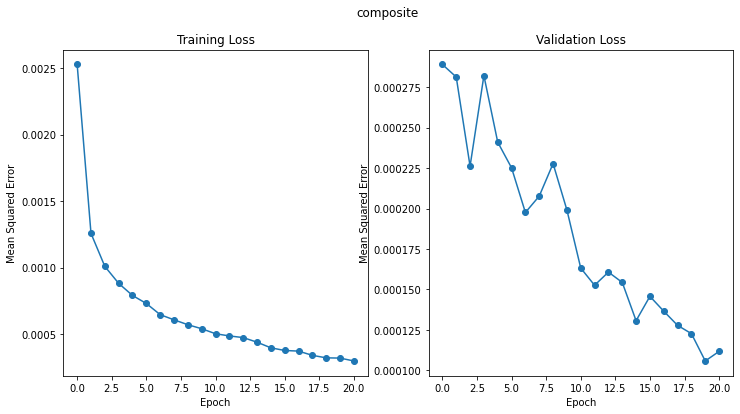

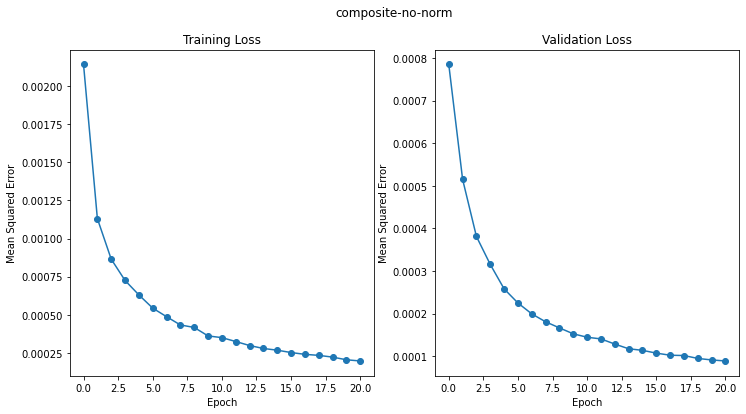

In [13]:
for item in path_list:
    dual_plot(item)

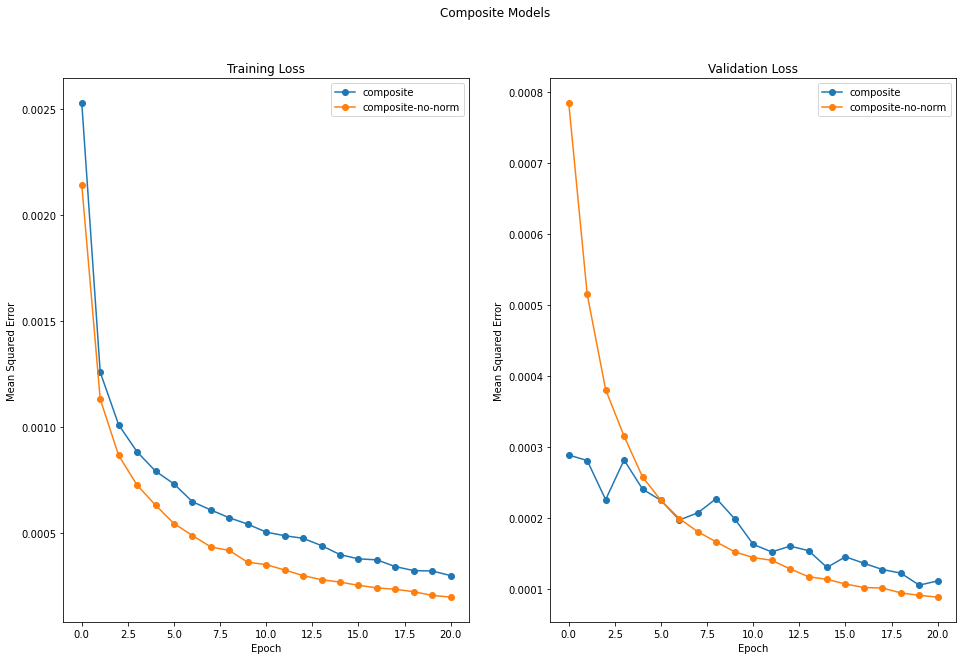

In [15]:
# Plot Groups - Composite
list_comp = [
    (e12_name,e12),
    (e13_name,e13)
]
dual_plot_composite(list_comp,title="Composite Models",figsize=(16,10))

In [17]:
# Given Data and Checkpoint, Run Inference and Return Loss
def run_inference_test(path_list_item,dataloader,data,backup=False):
    # Create Net
    transform = path_list_item[2]
    loss_list = list()
    for i in range(0,25,5):
        set_data_transform(transform,data)
        net = network(alpha=0,ip_dim=data[0]['image'].size())
        epoch,loss = load_model(net,net.optimizer,os.path.join(root,path_list_item[1],'{}-{}.pt'.format(path_list_item[0],i)))
        loss = run_inference(net,dataloader,get_device(),dataset=data)
        loss_list.append(loss)
    
    if backup == True:
        save_stats(loss_list,os.path.join(root,path_list_item[1],"held-out_loss.pkl"))
    return loss_list

In [18]:
# Load Test Data
test_data = loaded_test_dataset(os.path.join(root,"Demo","Demo_Files"),transform=None)
test_loader = DataLoader(test_data,batch_size=20)

In [19]:
def tri_plot(path_list):
    range1 = get_stat_data(path_list[1],file='train')
    range2 = get_stat_data(path_list[1],file='test')
    range3 = get_stat_data(path_list[1],file='held-out')
    plt.figure(figsize=(22, 6))
    plt.suptitle(path_list[0])
    ax1 = plt.subplot(1,3,1)
    axis_plot(ax1,range1,title="Training Loss",label=None)
    ax2 = plt.subplot(1,3,2)
    axis_plot(ax2,range2,title="Validation Loss",label=None)
    ax3 = plt.subplot(1,3,3)
    axis_plot(ax3,range3,title="Test Loss",label=None,xlabel_list=True)
    plt.show()


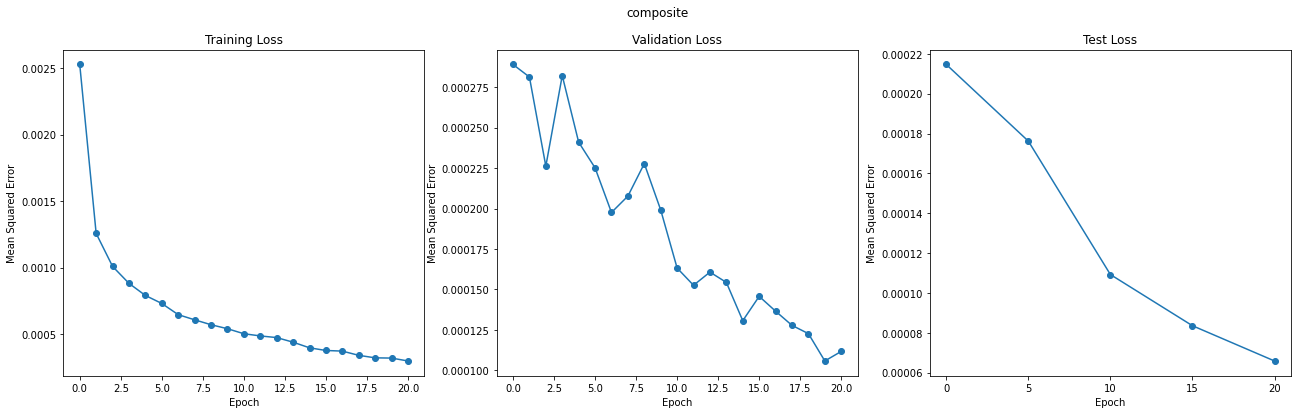

In [20]:
tri_plot(path_list[0])

In [21]:
def tri_plot_composite(path_list,title=None,figsize=(25, 14)):
    plt.figure(figsize=figsize)
    plt.suptitle(title)
    ax1 = plt.subplot(1,3,1)
    ax1.grid()
    ax2 = plt.subplot(1,3,2)
    ax2.grid()
    ax3 = plt.subplot(1,3,3)
    ax3.grid()
    for item in path_list:
        range1 = get_stat_data(item[1],file='train')
        range2 = get_stat_data(item[1],file='test')
        range3 = get_stat_data(item[1],file='held-out')
        axis_plot(ax1,range1,title="Training Loss",label=item[0])
        axis_plot(ax2,range2,title="Validation Loss",label=item[0])
        axis_plot(ax3,range3,title="Test Loss",label=item[0],xlabel_list=True)
    plt.show()

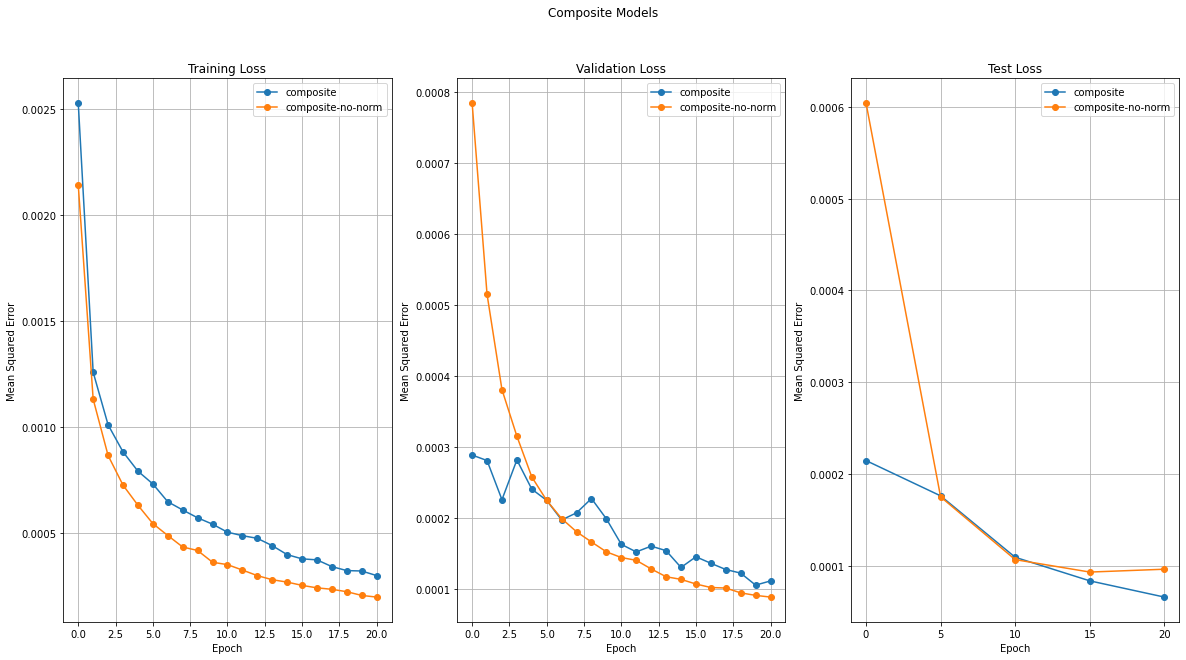

In [22]:
tri_plot_composite(list_comp,title="Composite Models",figsize=(20,10))

In [44]:
from torchvision import transforms
from matplotlib.pyplot import imshow
import numpy as np
def show_image(ds_image):
    im = transforms.ToPILImage()(ds_image).convert("RGB")
    imshow(np.asarray(im))

In [45]:
dataset_item = (e12_name,e12,['ccrop','gs','norm'])
set_data_transform(dataset_item[2],test_data)
net_final = network(alpha=0,ip_dim=test_data[0]['image'].size())
epoch,loss = load_model(net_final,net_final.optimizer,os.path.join(root,dataset_item[1],'{}-{}.pt'.format(dataset_item[0],20)))

None
['ccrop', 'gs', 'norm']


['ccrop', 'gs', 'norm']
None


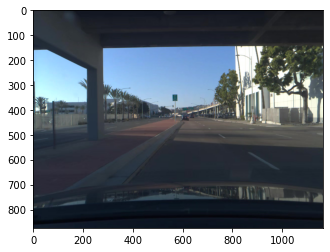

In [46]:
sample_ind = 900
set_data_transform(None,test_data)
ip = test_data[sample_ind]['image']
show_image(ip)

None
['ccrop', 'gs', 'norm']


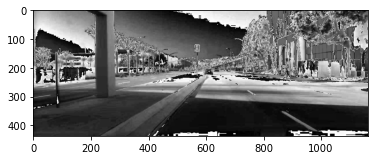

In [47]:
set_data_transform(dataset_item[2],test_data)
ip = test_data[sample_ind]['image']
show_image(ip)

In [48]:
run_inference_single(net_final,test_data[sample_ind],get_device())

Num = 1
Len = 1
Test Set Average Loss 0.0000
Real = tensor([[0.0123, 0.0527]], device='cuda:0', dtype=torch.float64)
Pred = tensor([[0.0102, 0.0538]], device='cuda:0', dtype=torch.float64)


tensor([[0.0102, 0.0538]], device='cuda:0', dtype=torch.float64)